# Sentiment Analysis of IMDB Reviews using LSTM

# Table of Contents

1. [Data Preparation and Visualization](#Data-Preparation-and-Visualization)
    - [Loading the Dataset]
    - [Word Frequency Analysis]
    - [Review Length Analysis]
    - [Word Clouds for Reviews]
2. [Building and Training the LSTM Model](#Building-and-Training-the-LSTM-Model)
    - [Model Architecture]
    - [Model Training]
3. [Evaluating Model Performance](#Evaluating-Model-Performance)
    - [Loss and Accuracy Plots]
    - [Confusion Matrix]
    - [Sample Predictions]

# Importing Libraries

In [1]:
# TensorFlow and Keras for building the neural network
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
# Matplotlib for plotting, Seaborn for advanced visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# WordCloud for text visualization
from wordcloud import WordCloud
# NumPy for numerical operations
import numpy as np
from collections import Counter
# Sklearn for model evaluation metrics,
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer
import pandas as pd
import string
from sklearn.model_selection import train_test_split

<a id="Data-Preparation-and-Visualization"></a>
# Data Preparation and Visualization
---

In [2]:
# Load the dataset
df = pd.read_csv('./IMDB Dataset.csv')

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

In [4]:
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

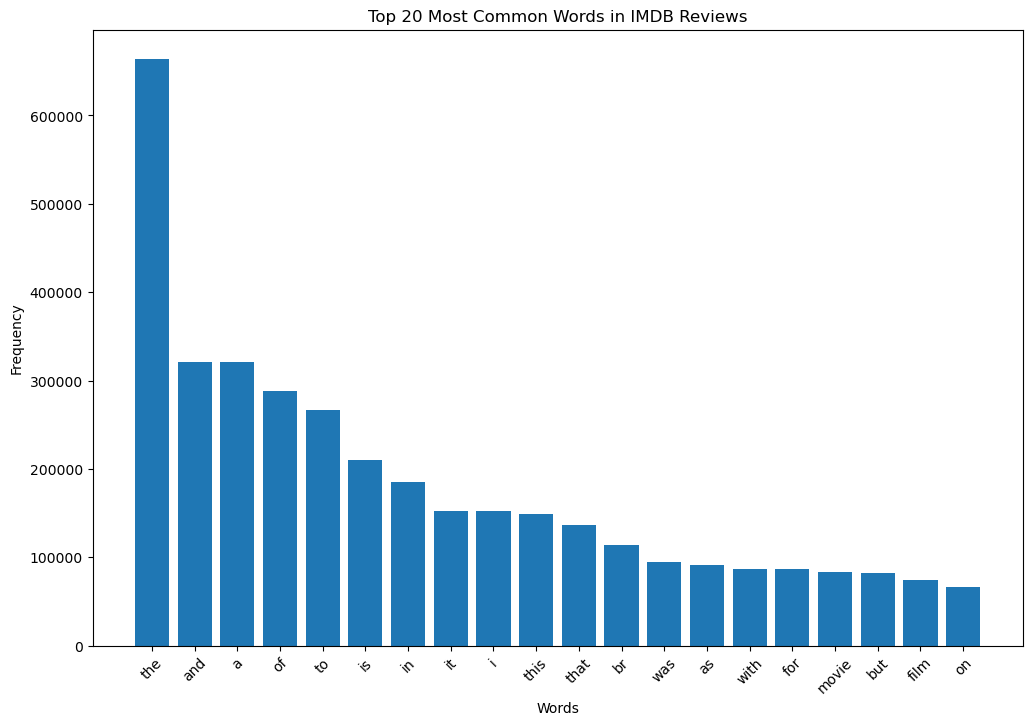

In [5]:
# Combine all reviews into a single string
all_reviews = ' '.join(df['review'])
# Convert to lowercase
all_reviews = all_reviews.lower()
# Remove punctuation
all_reviews = all_reviews.translate(str.maketrans('', '', string.punctuation))
# Tokenize (split the reviews into words)
words = all_reviews.split()
# Count the word frequencies
word_freq = Counter(words)
# Most common words
most_common_words = word_freq.most_common(20)

# Extracting words and their frequencies for plotting
words, frequencies = zip(*most_common_words)

# Creating a bar plot
plt.figure(figsize=(12, 8))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words in IMDB Reviews')
plt.xticks(rotation=45)
plt.show()

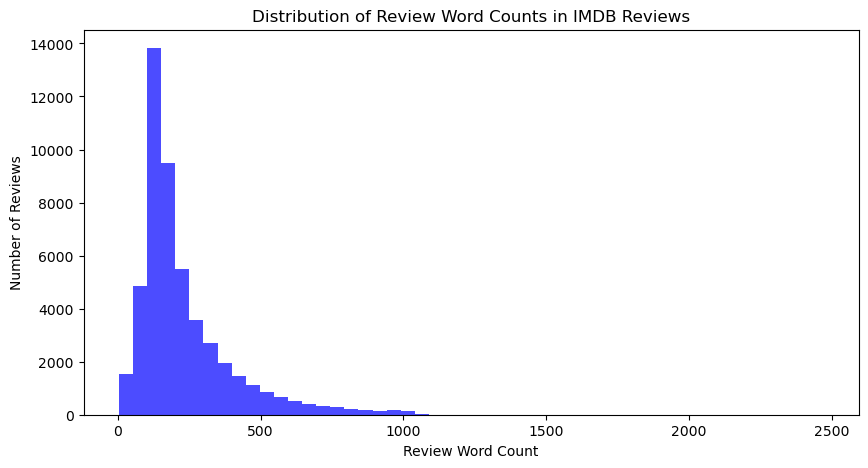

Mean review word count: 231.15694
Median review word count: 173.0


In [6]:
# Review Length Analysis
# Calculate the number of words in each review
review_word_counts = df['review'].apply(lambda review: len(review.split()))

# Plotting the distribution of review word counts
plt.figure(figsize=(10, 5))
plt.hist(review_word_counts, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Review Word Counts in IMDB Reviews')
plt.xlabel('Review Word Count')
plt.ylabel('Number of Reviews')
plt.show()

# Calculate mean and median of review word counts
mean_word_count = np.mean(review_word_counts)
median_word_count = np.median(review_word_counts)
print("Mean review word count:", mean_word_count)
print("Median review word count:", median_word_count)

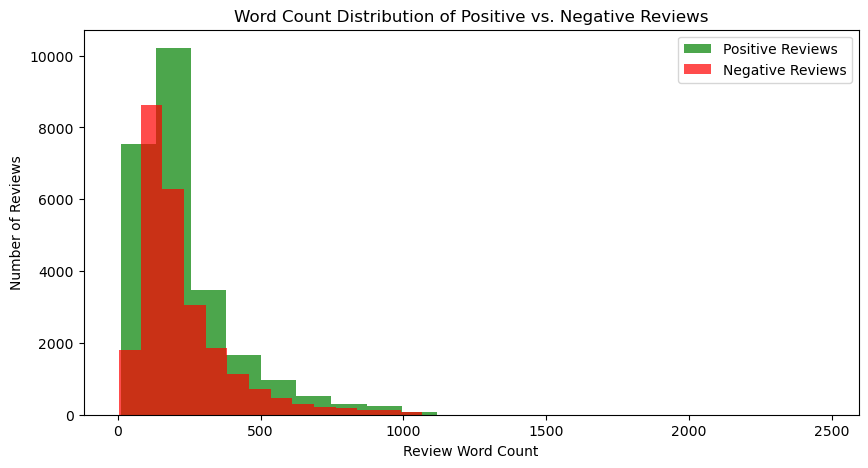

In [7]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Calculate word counts in reviews
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

# Separate word counts for positive and negative reviews
positive_word_counts = df[df['label'] == 1]['word_count']
negative_word_counts = df[df['label'] == 0]['word_count']

# Plotting
plt.figure(figsize=(10, 5))
plt.hist(positive_word_counts, bins=20, alpha=0.7, label='Positive Reviews', color='green')
plt.hist(negative_word_counts, bins=20, alpha=0.7, label='Negative Reviews', color='red')
plt.xlabel('Review Word Count')
plt.ylabel('Number of Reviews')
plt.title('Word Count Distribution of Positive vs. Negative Reviews')
plt.legend()
plt.show()


In [8]:
# Function to Generate Word Cloud
def generate_word_cloud(text_data):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

Word Cloud for Positive Reviews


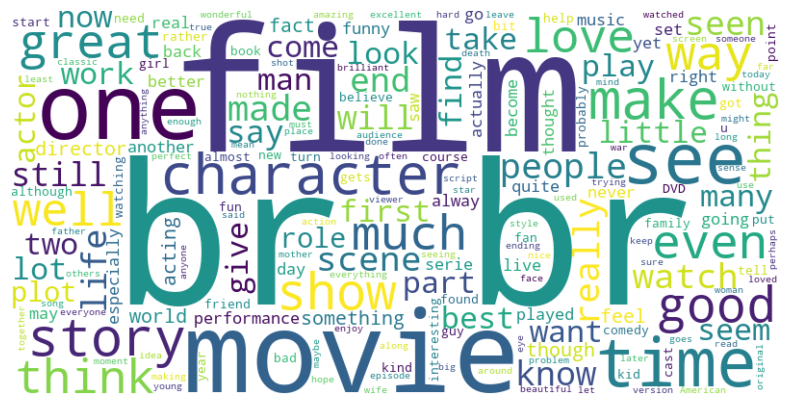

In [9]:
# Generating Word Clouds for Positive Reviews
positive_reviews = df[df['label'] == 1]['review']
print("Word Cloud for Positive Reviews")
generate_word_cloud(positive_reviews)

Word Cloud for Negative Reviews


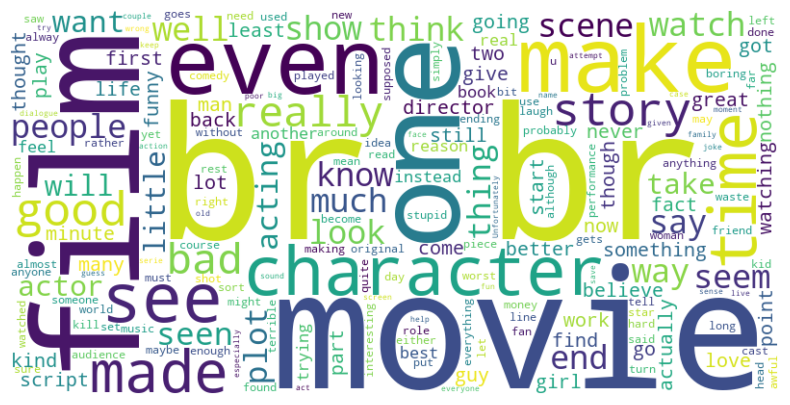

In [10]:
# Generating Word Clouds for Negative Reviews
negative_reviews = df[df['label'] == 0]['review']
print("Word Cloud for Negative Reviews")
generate_word_cloud(negative_reviews)

<a id="Building-and-Training-the-LSTM-Model"></a>
## Building and Training the LSTM Model
---



In [12]:
reviews = df['review'].values
labels = df['sentiment'].map({'positive': 1, 'negative': 0}).values

# Tokenizing the text
tokenizer = Tokenizer(num_words=10000)  # Adjust num_words as needed
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Padding the sequences
max_len = 350  # Length is chosen based on analysis of review lengths
data_padded = pad_sequences(sequences, maxlen=max_len)
train_data, test_data, train_labels, test_labels = train_test_split(data_padded, labels, test_size=0.5, random_state=42)

In [ ]:
# Defining the LSTM Model
# The model consists of an Embedding layer, an LSTM layer, and a Dense output layer
model = Sequential([
    Embedding(10000, 16, input_length=max_len),  # Turns positive integers (indexes) into dense vectors of fixed size
    LSTM(32, dropout=0.3),  # LSTM layer with 32 units and 30% dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the Model
# RMSprop optimizer is used with binary crossentropy loss, as it's a binary classification problem
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Training the Model
# The model is trained for 10 epochs with a batch size of 128
# 20% of the training data is used as a validation set to monitor the model's performance
model_checkpoint = ModelCheckpoint('trained_model.h5', save_best_only=True)
history = model.fit(train_data, train_labels, epochs=10, batch_size=128, validation_split=0.2, callbacks=[model_checkpoint])

<a id="Evaluating-Model-Performance"></a>
# Evaluating Model Performance
---

In [ ]:
# Evaluate model on test data
loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")

In [ ]:
# Plotting Loss per Epoch
# Training Loss and Validation Loss are plotted to understand the learning trends
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy per Epoch
# Training Accuracy and Validation Accuracy are plotted for performance insights
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Confusion Matrix
# Provides a summary of prediction results on a classification problem
# Helpful to see the model's performance in terms of false positives, false negatives, etc.

# Predicting Test Data
y_pred_classes = (model.predict(test_data) > 0.5).astype("int32")

# Creating the Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

<a id="Sample-Predictions"></a>
# Sample Predictions

#### Making Predictions on Sample Test Data. This section showcases how the model performs on unseen data. It compares the predicted sentiment against the actual sentiment

In [ ]:
# Sample some test data for predictions
sample_data = test_data[:10]
sample_labels = test_labels[:10]  # Corresponding true labels

# Model Predictions
predictions = model.predict(sample_data)

# For each prediction, determine the predicted and actual sentiment
for i, pred in enumerate(predictions):
    predicted_sentiment = "Positive" if pred > 0.5 else "Negative"
    actual_sentiment = "Positive" if sample_labels[i] == 1 else "Negative"
    print(f"Review {i}: Predicted Sentiment - {predicted_sentiment}, Actual Sentiment - {actual_sentiment}")
